In [59]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                        MultiComparison)
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(12, 6)}, style="whitegrid")

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

In [60]:
photo_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-bagirjan/Statistics/LESSON_5/5_task_1.csv')

In [61]:
photo_df

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [62]:
A = photo_df.query('group == "A"').events
B = photo_df.query('group == "B"').events
C = photo_df.query('group == "C"').events

In [63]:
ss.levene(A, B, C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [64]:
#OR через библиотеку pingouin

pg.homoscedasticity(data = photo_df, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


Дисперсии равны, поскольку нулевой гипотезой теста Левена является равенство дисперсий. Pvalue > 0.05

Проверим являются ли распредения нормальными

In [65]:
print(ss.normaltest(A))
print(ss.normaltest(B))
print(ss.normaltest(C))

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


In [66]:
#OR через библиотеку pingouin
pg.normality(data=photo_df, group='group', dv='events', method='normaltest')

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


Наши данные распределены нормально

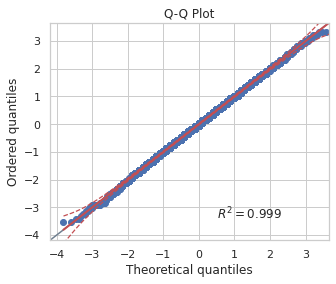

In [67]:
#Дополнительно выведем qq-plot для этих распределений
pg.qqplot(A)

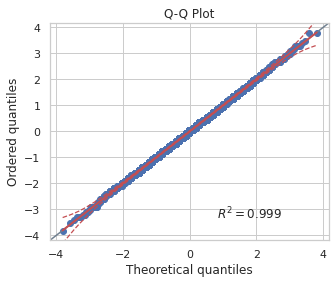

In [68]:
pg.qqplot(B)

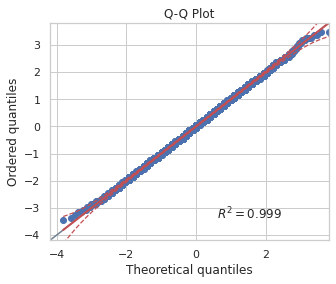

In [69]:
pg.qqplot(C)

R2 на плоте показывает, как происходит корреляция между нашими данными и теоритическими данными норм. распределения
чем больше число, тем больше вероятность,что распред. нормальное. 
Чем меньше число, тем больше вероятность, что распред. не нормальное

Cравним наши три группы с нормальным распределением с помощью ANNOVA (ОДНОФАКТОРНЫЙ ДИСПЕРСИОННЫЙ АНАЛИЗ)

In [70]:
#Через библиотеку scipy.stats
ss.f_oneway(photo_df.query('group == "A"').events,
            photo_df.query('group == "B"').events,
            photo_df.query('group == "C"').events)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [71]:
#OR через pingouin
pg.anova(data=photo_df, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Группы между собой статистически различаются. Но какие именно группы?

Добавим критерий Тьюки и определим, между какими группами есть статистически значимые различия

In [72]:
# через pingouin
pg.pairwise_tukey(data=photo_df, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


p-tukey = 0.001

hedges - Показывает в единицах стандартного отклонения, на сколько средние друг от друг отличаются

In [73]:
#OR через stats.models
MultiComparison(photo_df.events, photo_df.group).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


Во всех случаях мы имеем статистически значимые различия. Отклоняем нулевую гипотезу. Проверим этот результат с помощью двухвыборочного Т-теста для независимых выборок. Также мы определили наиболее отличающуюся группу - В. Это наиболее привлекательный для посетителей размер фотографий в меню.

In [74]:
ss.ttest_ind(A, B)

Ttest_indResult(statistic=-57.01113423437213, pvalue=0.0)

In [75]:
ss.ttest_ind(A, C)

Ttest_indResult(statistic=14.886135128440298, pvalue=7.500261656295871e-50)

In [76]:
ss.ttest_ind(B, C)

Ttest_indResult(statistic=72.42022029192773, pvalue=0.0)

Text(0, 0.5, 'число покупок')

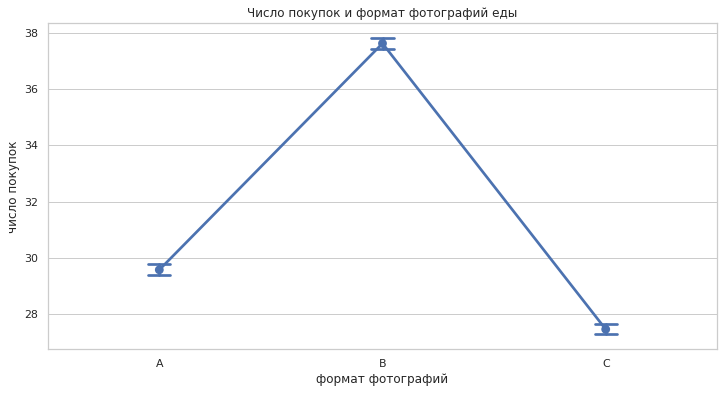

In [77]:
#нарисуем, чтобы проще было смотреть

sns.pointplot(x='group', y='events', data=photo_df, capsize = .1)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('формат фотографий')
plt.ylabel('число покупок')

Подтверждаем

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [78]:
button_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-bagirjan/Statistics/LESSON_5/5_task_2.csv')

In [79]:
button_df.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


Для начала визуализируем распределение events для контрольной и тестовой групп.

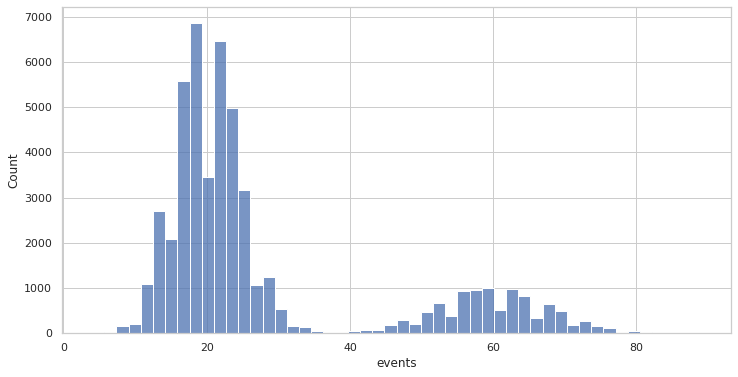

In [80]:
sns.histplot(x=button_df.query('group == "control"').events, bins=50)

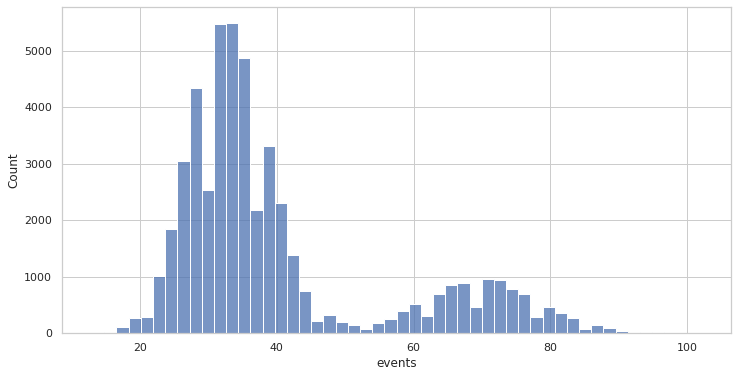

In [81]:
sns.histplot(x=button_df.query('group == "test"').events, bins=50)

Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [82]:
button_df.groupby(['group', 'segment'])\
    .agg({'events' : ['mean', 'median', 'std']}).round(2)

events             
                  mean median   std
group   segment                    
control high     59.97   60.0  7.81
        low      20.03   20.0  4.47
test    high     69.94   70.0  8.40
        low      33.03   33.0  5.72

Выберем формулу для модели. Напомним, что мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.

events ~ segment + group + segment:group

Проведем тест (через anova_lm либо pg.anova), а затем используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

In [83]:
#ANOVA in pingouin
pg.anova(data=button_df, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


Мы получили статистически значимые различия.

Для дальнейших сравнений необходимо объединить столбцы групп и сегментов


In [84]:
#Создаем колонку комбинация

button_df['combination'] = button_df.group + '\\' + button_df.segment

In [85]:
#Тьюкей через пингвин

pg.pairwise_tukey(data=button_df, dv='events', between='combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control\high,control\low,59.970800,20.031575,39.939225,0.065432,610.391461,0.001,6.824282
1,control\high,test\high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.001,-1.703109
2,control\high,test\low,59.970800,33.025925,26.944875,0.065432,411.798717,0.001,4.603981
3,control\low,test\high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.001,-8.527429
4,control\low,test\low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.001,-2.220314
5,test\high,test\low,69.938500,33.025925,36.912575,0.065432,564.135148,0.001,6.307128


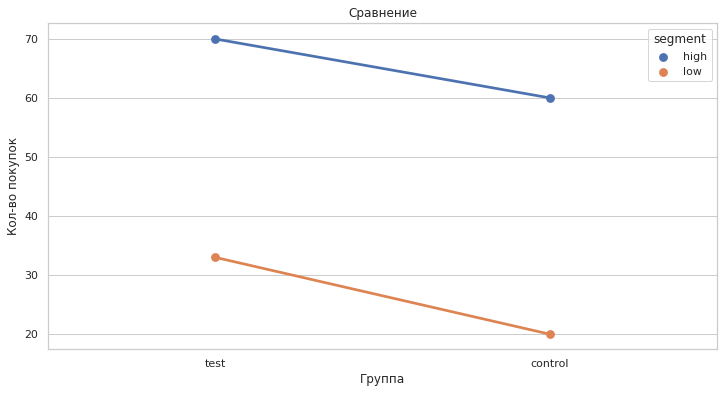

In [88]:
sns.pointplot(x='group', y='events', hue='segment', data=button_df)
plt.title('Сравнение')
plt.xlabel('Группа')
plt.ylabel('Кол-во покупок')
plt.show()

Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой
Разница между control/high и test/high составила около 10
Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13

Фактор group оказался ЗНАЧИМЫМ , фактор segment – ЗНАЧИМЫМ , их взаимодействие – ЗНАЧИМО . Судя по графику, для всех групп среднее значение events УВЕЛИЧИЛОСЬ , поэтому решение: ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ